In [ ]:
!pip install pyvirtualdisplay
!apt-get install -y xvfb x11-utils


In [ ]:
!apt-get install swig
!pip install box2d-py


Episode 1/500, Score: -3.20, Avg Score: -3.20, Epsilon: 0.98
Episode 2/500, Score: -469.07, Avg Score: -236.13, Epsilon: 0.90
Episode 3/500, Score: -96.95, Avg Score: -189.74, Epsilon: 0.78
Episode 4/500, Score: -165.36, Avg Score: -183.64, Epsilon: 0.69
Episode 5/500, Score: -232.56, Avg Score: -193.43, Epsilon: 0.60
Episode 6/500, Score: -169.77, Avg Score: -189.48, Epsilon: 0.48
Episode 7/500, Score: 1.60, Avg Score: -162.19, Epsilon: 0.40
Episode 8/500, Score: -32.90, Avg Score: -146.03, Epsilon: 0.30
Episode 9/500, Score: -116.91, Avg Score: -142.79, Epsilon: 0.10
Episode 10/500, Score: -141.28, Avg Score: -142.64, Epsilon: 0.01
Episode 11/500, Score: -94.87, Avg Score: -138.30, Epsilon: 0.01
Episode 12/500, Score: -172.83, Avg Score: -141.17, Epsilon: 0.01
Episode 13/500, Score: -96.47, Avg Score: -137.74, Epsilon: 0.01
Episode 14/500, Score: -125.51, Avg Score: -136.86, Epsilon: 0.01
Episode 15/500, Score: -293.51, Avg Score: -147.31, Epsilon: 0.01
Episode 16/500, Score: 14.30, 

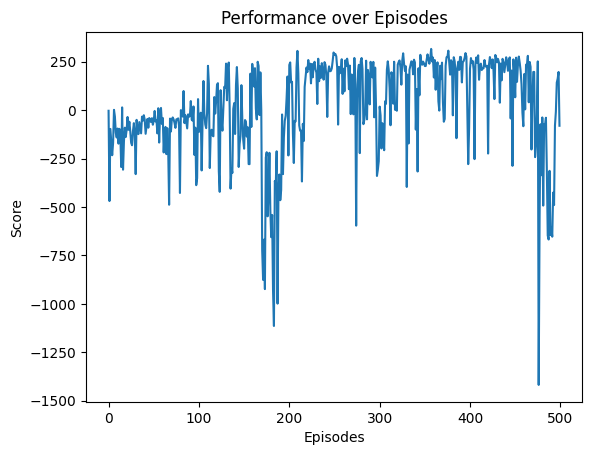

Total Reward: 303.8262507423765
Video saved as lunar_lander_performance.mp4
Video saved as lunar_lander_performance.mp4


In [17]:
import gym
import torch as T
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import cv2

class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
        super(DeepQNetwork, self).__init__()
        self.fc1 = nn.Linear(*input_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.fc3 = nn.Linear(fc2_dims, n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = T.relu(self.fc1(state))
        x = T.relu(self.fc2(x))
        actions = self.fc3(x)
        return actions

class Agent:
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=1000000, eps_end=0.01, eps_dec=5e-4, target_update_freq=10):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.learn_step_counter = 0
        self.target_update_freq = target_update_freq

        self.Q_eval = DeepQNetwork(lr, input_dims, 256, 256, n_actions)
        self.Q_target = DeepQNetwork(lr, input_dims, 256, 256, n_actions)
        self.Q_target.load_state_dict(self.Q_eval.state_dict())

        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation]).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        return action

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, self.batch_size, replace=False)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]

        q_eval = self.Q_eval.forward(state_batch)[range(self.batch_size), action_batch]
        q_next = self.Q_target.forward(new_state_batch).max(dim=1)[0]
        q_next[terminal_batch] = 0.0

        q_target = reward_batch + self.gamma * q_next

        loss = self.Q_eval.loss(q_eval, q_target).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.epsilon = max(self.epsilon - self.eps_dec, self.eps_min)

        if self.learn_step_counter % self.target_update_freq == 0:
            self.Q_target.load_state_dict(self.Q_eval.state_dict())

        self.learn_step_counter += 1

def create_video(frames, fps=30, output_name='output_video'):
    if len(frames) == 0:
        print("No frames to save.")
        return
    if not isinstance(frames[0], np.ndarray):
        print(f"Unexpected frame type: {type(frames[0])}. Expected numpy.ndarray.")
        return
    height, width, _ = frames[0].shape
    out = cv2.VideoWriter(output_name + '.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    for frame in frames:
        out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    out.release()
    print(f'Video saved as {output_name}.mp4')

def train_lunar_lander(n_episodes=500):
    env = gym.make('LunarLander-v2')
    input_dims = [env.observation_space.shape[0]]
    n_actions = env.action_space.n
    agent = Agent(gamma=0.99, epsilon=1.0, lr=0.001, input_dims=input_dims,
                  batch_size=64, n_actions=n_actions, eps_end=0.01, eps_dec=1e-3)

    scores, eps_history = [], []

    for i in range(n_episodes):
        state = env.reset()
        done = False
        score = 0

        while not done:
            action = agent.choose_action(state)
            state_, reward, done, _ = env.step(action)
            agent.store_transition(state, action, reward, state_, done)
            agent.learn()
            state = state_
            score += reward

        scores.append(score)
        eps_history.append(agent.epsilon)

        avg_score = np.mean(scores[-100:])
        print(f'Episode {i+1}/{n_episodes}, Score: {score:.2f}, Avg Score: {avg_score:.2f}, Epsilon: {agent.epsilon:.2f}')

    T.save(agent.Q_eval.state_dict(), 'lunar_lander_dqn.pth')

    plt.plot(scores)
    plt.xlabel('Episodes')
    plt.ylabel('Score')
    plt.title('Performance over Episodes')
    plt.show()

    env.close()
def evaluate_lunar_lander_with_video(output_name='lunar_lander_video'):
    env = gym.make('LunarLander-v2', render_mode='rgb_array')
    input_dims = [env.observation_space.shape[0]]
    n_actions = env.action_space.n

    agent = Agent(gamma=0.99, epsilon=0.01, lr=0.001, input_dims=input_dims,
                  batch_size=64, n_actions=n_actions)
    agent.Q_eval.load_state_dict(T.load('lunar_lander_dqn.pth', weights_only=True))

    state = env.reset()
    done = False
    total_reward = 0
    frames = []

    while not done:
        action = agent.choose_action(state)
        state, reward, done, info = env.step(action)
        frame = np.array(env.render(mode='rgb_array'))

        if frame.ndim == 4:
            frame = frame[0]

        if isinstance(frame, np.ndarray):
            frames.append(frame)
        else:
            print(f"Error: Frame is not a valid ndarray. Got {type(frame)}")

        total_reward += reward

    print(f'Total Reward: {total_reward}')
    env.close()

    if len(frames) > 0:
        if len(frames[0].shape) == 2:
            height, width = frames[0].shape
            channels = 1
        elif len(frames[0].shape) == 3:
            height, width, channels = frames[0].shape
        else:
            print(f"Unexpected frame shape: {frames[0].shape}")
            return

        create_video(frames, fps=30, output_name=output_name)
    else:
        print("No frames to save.")

    print(f'Video saved as {output_name}.mp4')

train_lunar_lander()
evaluate_lunar_lander_with_video('lunar_lander_performance')
